# Задача:
    
Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

1. Визуальный анализ ряда
2. Стабилизация дисперсии (при необходимости)
3. Выбор порядка дифференцирования
4. Выбор начальных приближений для p, q, P, Qp,q,P,Q
5. Обучение и сравнение моделей-кандидатов, выбор победителя
6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Qp,q,P,Q.
7. Прогнозирование с помощью финальной модели.

## 1. Импорт библиотек и чтение данных.

In [ ]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


D:\setup\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<Figure size 1080x504 with 0 Axes>

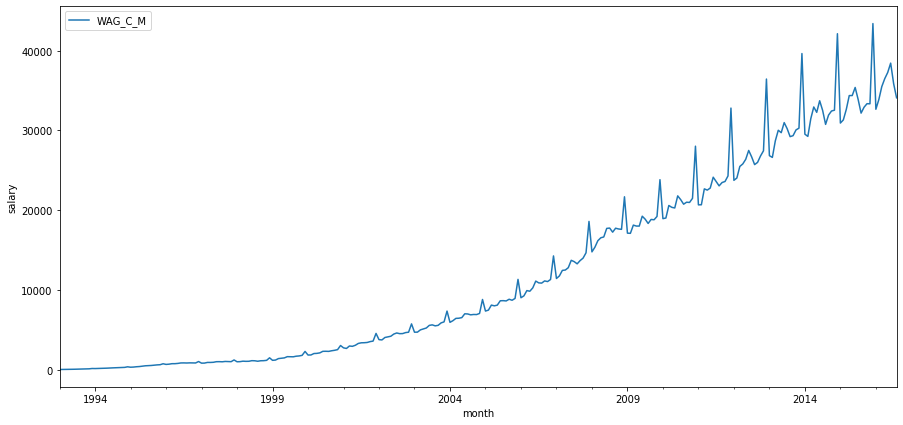

In [ ]:
# чтение файла и вывод

salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

plt.figure(figsize(15,7))
salary.plot()
plt.ylabel('salary')
pylab.show()

In [ ]:
salary

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


### Визуальный анализ ряда:

У ряда наблюдается четкий тренд. Также заметно увеличение размаха дисперсии. Можно предположить, что ряд нестационарен.
Проверим это формально.
    

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

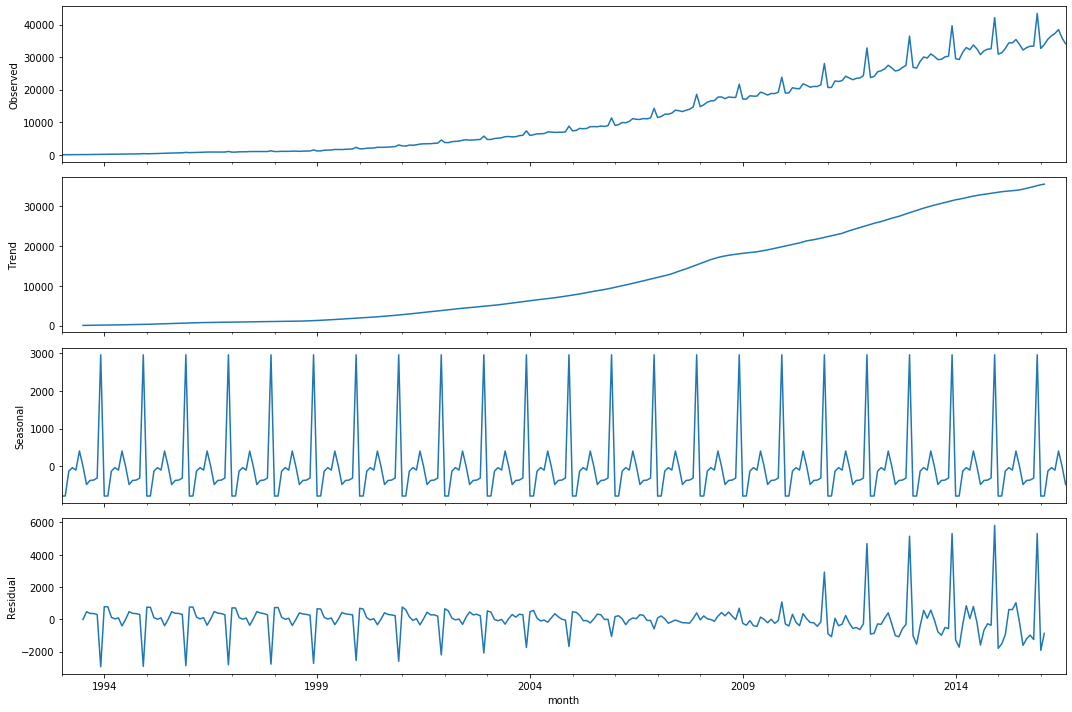

In [ ]:
# проверка нестационарности. Гипотеза не отвеграется, но значения пограничны.

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary).plot()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

### Вывод:

Критерий Дики-ФУллера=0.9918 > 0.05 => гипотеза о нестационарности - не отвергается.

Кроме того, остатки (Residual) подчиняется определённой закономерности. Также можно заметить постоянное увеличение размаха дисперсии.

## 2. Стабилизация дисперсии

Делаем стабилизацию дисперсии при помощи метода Бокса-Кокса, чтобы сделать ряд стационарным

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


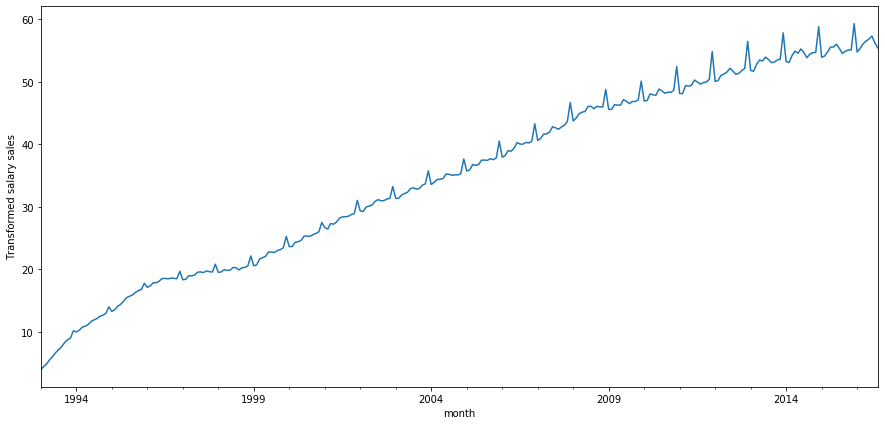

In [ ]:
salary['salary_box'], lmbda = stats.boxcox(salary.WAG_C_M)

plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel(u'Transformed salary sales')

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

In [ ]:
salary

,WAG_C_M,salary_box
month,,
1993-01-01,15.3,3.990393
1993-02-01,19.1,4.458758
1993-03-01,23.6,4.931635
1993-04-01,30.6,5.549430
1993-05-01,37.5,6.063406
...,...,...
2016-04-01,36497.0,56.526742
2016-05-01,37270.0,56.860441
2016-06-01,38447.0,57.358885


### Вывод:

Критерий Дики-Фуллера=0.696899 > 0.05 => гипотеза о нестационарности - не отвергается. К тому же, у ряда наблюдается тренд.

## 3. Выбор порядка дифференцирования

Чтобы убрать стационарность нужно провести дифферинцирование.
Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

#### 3.1. Только сезонное дифференцирование

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

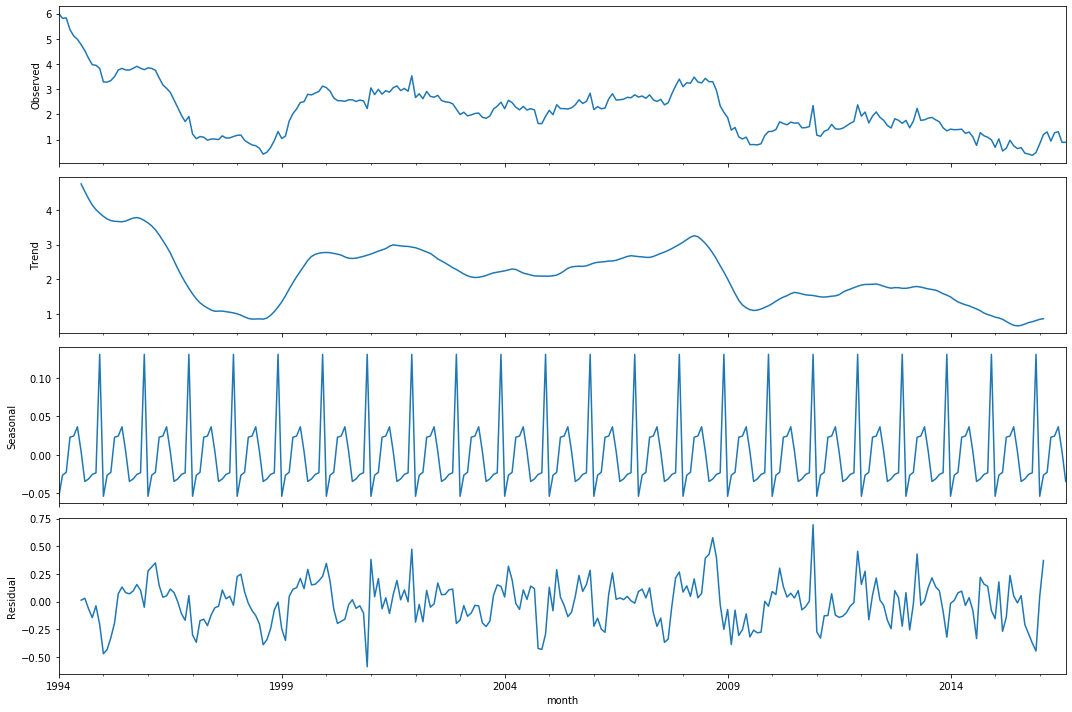

In [ ]:
salary['salary_box_diff12'] = salary.salary_box - salary.salary_box.shift(12) # сезонное дифференцирование

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff12[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff12[12:])[1])

### Выводы:
    
- Теперь остатки похожи на случайный шум
- Критерий Дики-Фуллера меньше 0,05

Но по-прежнему сохраняется некий тренд, он не колеблется около той или иной константы. А значит, ряд всё ещё нельзя считать стационарным.



#### 3.2. Только обычное дифференцирование

Критерий Дики-Фуллера: p=0.014396


<Figure size 1080x720 with 0 Axes>

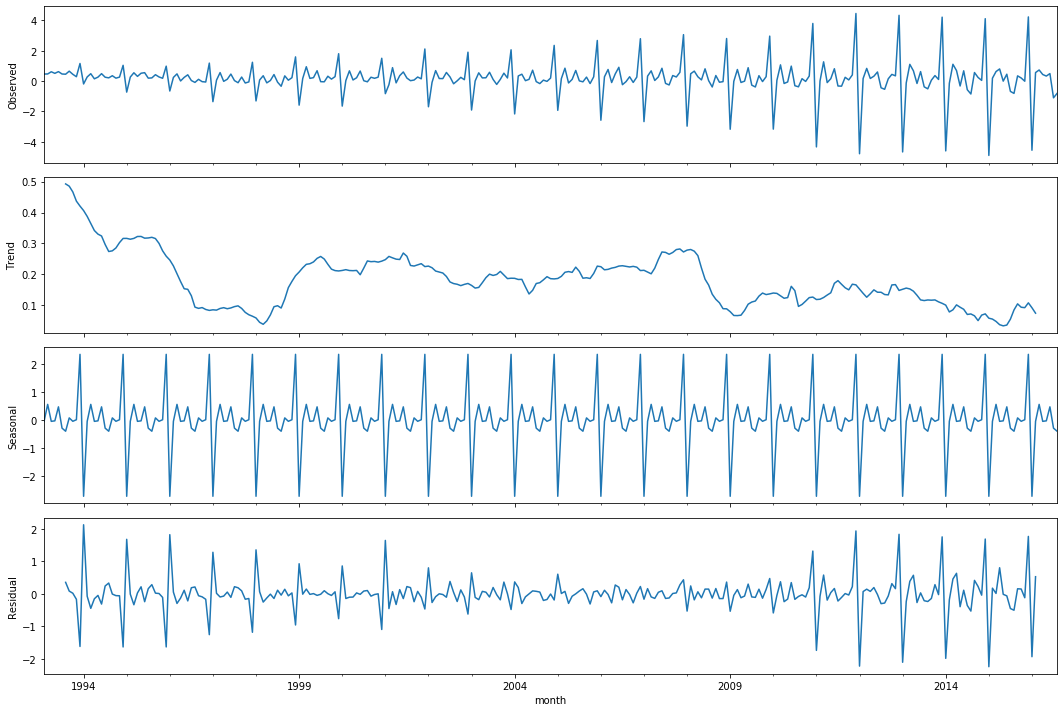

In [ ]:
salary['salary_box_diff1'] = salary.salary_box - salary.salary_box.shift(1) # обычное дифференцирование

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff1[1:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff1[1:])[1])

### Выводы:
    
- Теперь остатки приняли снова вид закономерности
- Заметно увеличение размаха дисперсии на первом графике
- Критерий Дики-Фуллера меньше 0,05

Но по-прежнему сохраняется некий тренд, он колеблется около той или иной константы. А значит, ряд всё ещё нельзя считать стационарным.

#### 3.3. Обычное дифференцирование после сезонного

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

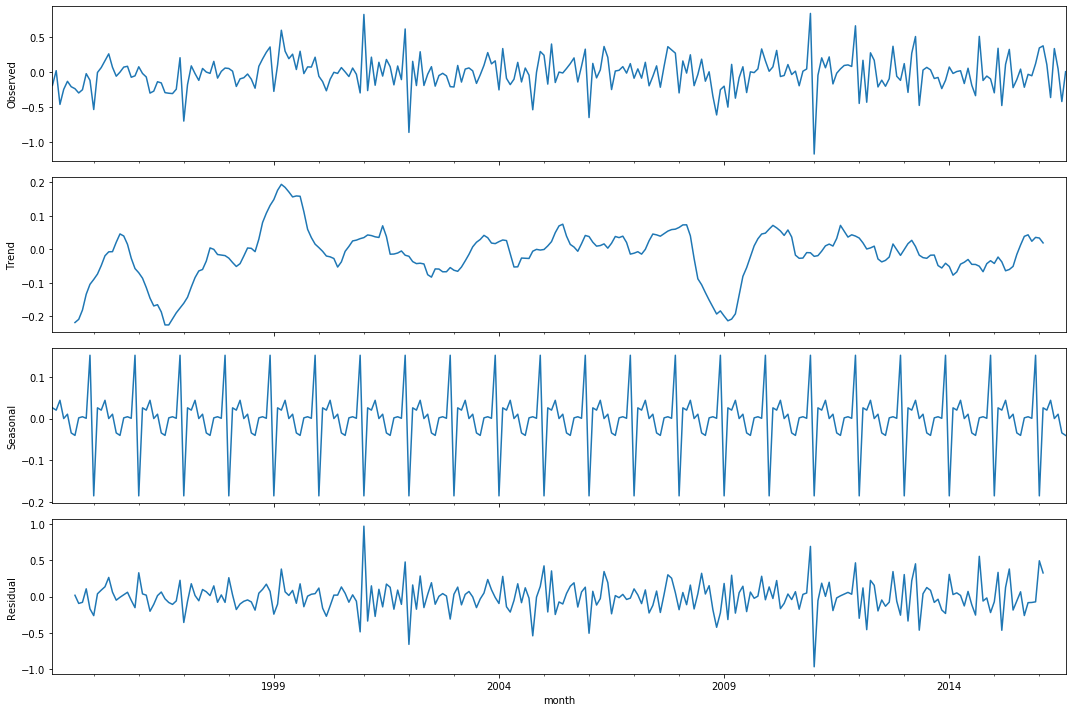

In [ ]:
salary['salary_box_diff2'] = salary.salary_box_diff12 - salary.salary_box_diff12.shift(1)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2[13:])[1])

### Вывод:

* тренд приблизился к колебанию около константы
* остатки имеют вид случайного шума
* критерий Дики-Фуллера стал равен нулю

Таким образом, мы можем считать этот ряд стационарным.

In [ ]:
salary

,WAG_C_M,salary_box,salary_box_diff12,salary_box_diff1,salary_box_diff2
month,,,,,
1993-01-01,15.3,3.990393,NaN,NaN,NaN
1993-02-01,19.1,4.458758,NaN,0.468365,NaN
1993-03-01,23.6,4.931635,NaN,0.472877,NaN
1993-04-01,30.6,5.549430,NaN,0.617795,NaN
1993-05-01,37.5,6.063406,NaN,0.513976,NaN
...,...,...,...,...,...
2016-04-01,36497.0,56.526742,0.942729,0.437734,-0.366210
2016-05-01,37270.0,56.860441,1.275065,0.333700,0.332336
2016-06-01,38447.0,57.358885,1.316994,0.498444,0.041929


Попробуем подобрать параметры для начального приближения

## 4. Выбор начальных приближений для p, q, P, Qp,q,P,Q

Посмотрим на ACF и PACF полученного ряда:

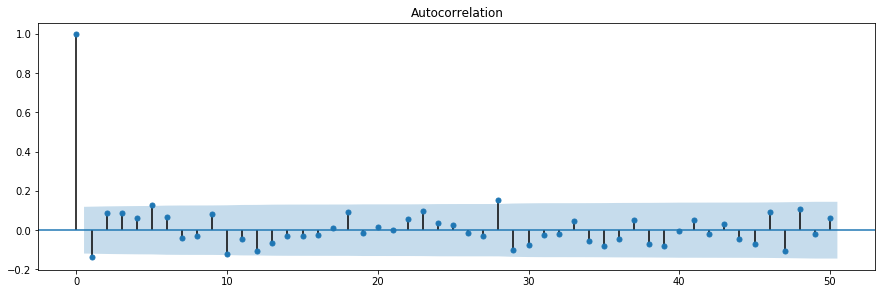

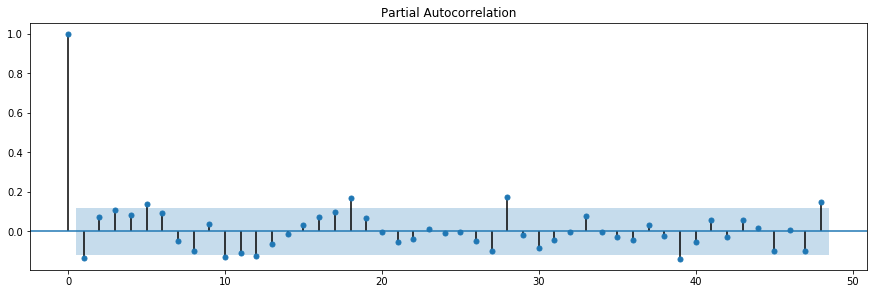

In [ ]:
# ACF

plt.figure(figsize(15,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

# PACF
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Вывод по ACF:

1. Максимальный сезонный лаг (12 м) вылезающий из синего коридора = 12 => Q = 1
2. Из несезонных зачимо отличается от 0 только 1 и 5 лаг => q = 2

Вывод по PACF:
    
1. Значимо отличающийся от коридора лаг = 18 => P = 1
2. Поскольку 2 лага значимо отличается, то возьмем p = 2

Итого:

In [ ]:
ps = range(0, 3)
d=1
qs = range(0, 3)

Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [ ]:
# наборы параметров

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

## 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [ ]:
# датафрейм на текущий момент


salary

,WAG_C_M,salary_box,salary_box_diff12,salary_box_diff1,salary_box_diff2,model
month,,,,,,
1993-01-01,15.3,3.990393,NaN,NaN,NaN,1.000000
1993-02-01,19.1,4.458758,NaN,0.468365,NaN,15.300000
1993-03-01,23.6,4.931635,NaN,0.472877,NaN,19.100000
1993-04-01,30.6,5.549430,NaN,0.617795,NaN,23.600000
1993-05-01,37.5,6.063406,NaN,0.513976,NaN,30.600000
...,...,...,...,...,...,...
2016-04-01,36497.0,56.526742,0.942729,0.437734,-0.366210,37250.938642
2016-05-01,37270.0,56.860441,1.275065,0.333700,0.332336,36899.022469
2016-06-01,38447.0,57.358885,1.316994,0.498444,0.041929,38744.942975


Получение моделей с данными параметрами

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

Wall time: 15.1 s


In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
32  (2, 2, 0, 0) -21.488595
34  (2, 2, 1, 0) -21.473461
33  (2, 2, 0, 1) -21.240102
35  (2, 2, 1, 1) -21.053116
22  (1, 2, 1, 0)  -8.134236


In [ ]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 12)   Log Likelihood                  15.744
Date:                            Mon, 17 Aug 2020   AIC                            -21.489
Time:                                    12:03:32   BIC                             -3.478
Sample:                                01-01-1993   HQIC                           -14.257
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4855      0.044     33.956      0.000       1.400       1.571
ar.L2         -0.6839      0.043   

## 6. Анализ остатков построенной модели, при необходимости — её модификация:

Если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P,Q.


Критерий Стьюдента: p=0.269829
Критерий Дики-Фуллера: p=0.000000


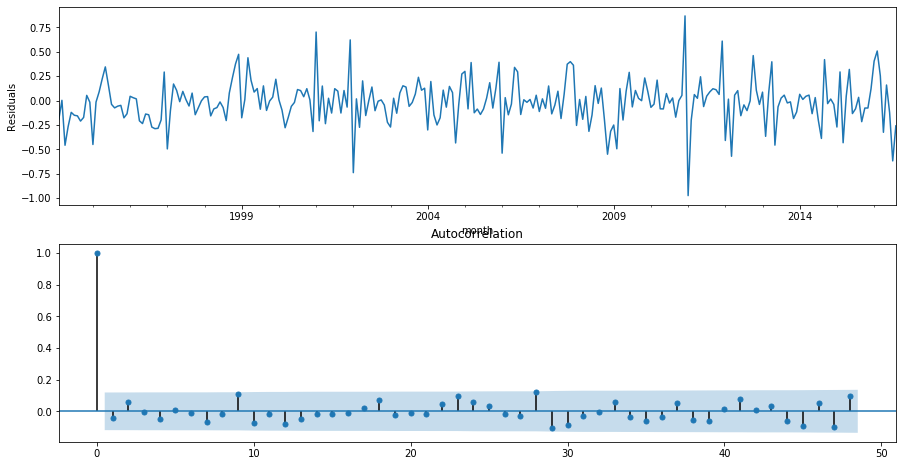

In [ ]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot() # остатки
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax) # автокорреляционная функция остатков

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) и стационарны (подтверждается критерием Дики-Фуллера и визуально).

Доверительный уровень значимости Люнга-Бокса = 0.67 (из print(best_model.summary())) > 0.05.
Значит, что гипотеза об автокоррелируемости остатков не отвергается.


Посмотрим, насколько хорошо модель описывает данные:

In [ ]:
best_model.fittedvalues

month
1993-01-01     0.000000
1993-02-01     3.990393
1993-03-01     4.458758
1993-04-01     4.931635
1993-05-01     5.549430
                ...    
2016-04-01    56.852274
2016-05-01    56.700935
2016-06-01    57.483273
2016-07-01    56.879197
2016-08-01    55.715276
Length: 284, dtype: float64

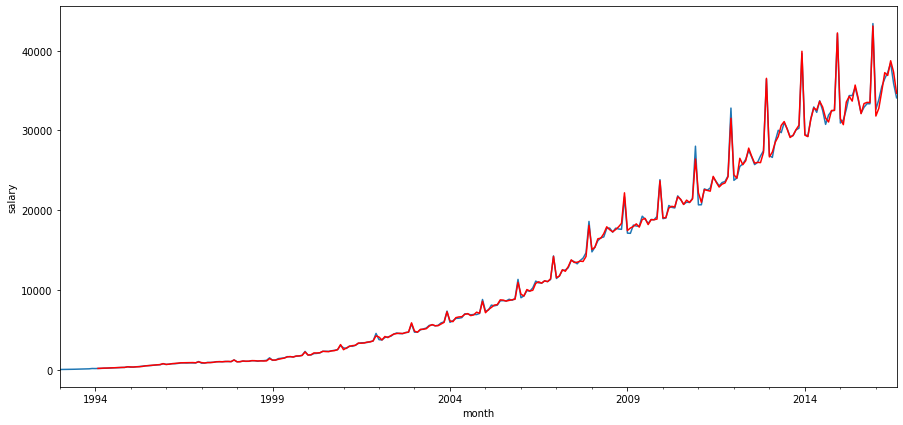

In [ ]:
# добавление данных по лучшей модели в датасет
salary['model'] = invboxcox(best_model.fittedvalues, lmbda) # добавление полученных значений модели в датасет

# построение тренда по изначальным данным
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()

# построение  тренда по модельным данным
salary.model[13:].plot(color='r')
plt.ylabel('salary')
pylab.show()

Полученная модель достаточно точно описывает данные

## 7. Прогнозирование с помощью финальной модели.

Рассчитаем начало и конец периода прогнозирования:

In [ ]:
starter = len(salary['WAG_C_M']) # количество дат в изначальном наборе данных
ender = starter + 12 * 2 # количество: начальный набор + 2 года

И сделаем прогноз:

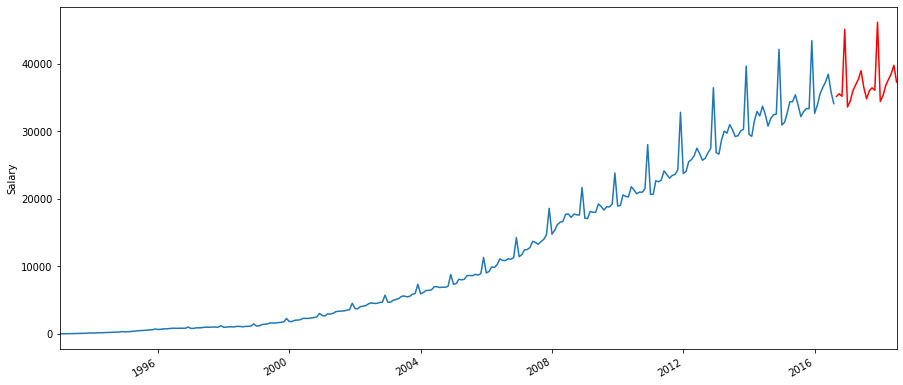

In [ ]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns=salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=starter, end=ender), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

In [ ]:
salary2

,WAG_C_M,forecast
1993-01-01,15.3,NaN
1993-02-01,19.1,NaN
1993-03-01,23.6,NaN
1993-04-01,30.6,NaN
1993-05-01,37.5,NaN
...,...,...
2018-03-01,NaN,36731.109422
2018-04-01,NaN,37651.990339
2018-05-01,NaN,38464.903665
2018-06-01,NaN,39774.277602


## Вывод:
    
Была построена модель, которая позволила спрогнозировать уровень средней ЗП в России на несколько следующих периодов.